## Rationale Behind Dataset Choice

The problem is to predict the (x, y) coordinates of a single white pixel in a 50x50 image. This is a well-defined and constrained problem, making it ideal for creating a synthetic dataset where each image has exactly one white pixel.

By using a 50x50 pixel grid, the problem complexity is controlled. The total number of possible positions for the white pixel is 2500 (50x50).

A dataset with 10,000 samples provides a sufficient amount of data for training and validation.


### How Data is Generated

The dataset is generated synthetically using the following steps:

1. **Generate a Single Image and Label**:
    - A function `generate_image_label(size=50)` is defined to create a 50x50 grayscale image where all pixels are black (value 0) except for one randomly placed white pixel (value 255).
    - The function returns the image and the coordinates of the white pixel.

2. **Generate the Entire Dataset**:
    - Another function `generate_dataset(num_samples, size=50)` is defined to create a dataset of a specified number of samples.
    - This function uses `generate_image_label` to generate the specified number of images and their corresponding labels.
    - The generated dataset is then converted to numpy arrays.

3. **Reshape and Normalize Images**:
    - The images are reshaped to add a channel dimension, making them compatible with convolutional neural networks.
    - The pixel values are normalized to the range [0, 1] by dividing by 255.

Images shape: (10000, 50, 50, 1)
Labels shape: (10000, 2)


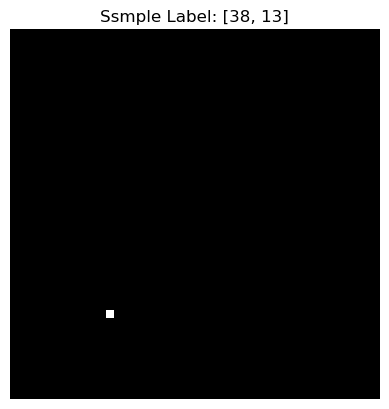

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def generate_image_label(size=50):
    """
    Generates a single 50x50 image with one white pixel and returns the image and the coordinates of the white pixel.
    
    Parameters:
    size (int): The size of the image (default is 50x50).
    
    Returns:
    tuple: A tuple containing the generated image and the coordinates of the white pixel.
    """
    image = np.zeros((size, size), dtype=np.uint8)
    x, y = np.random.randint(0, size, size=2)
    image[x, y] = 255
    return image, (x, y)

def generate_dataset(num_samples, size=50):
    """
    Generates a dataset of images and their corresponding labels.
    
    Parameters:
    num_samples (int): The number of samples to generate.
    size (int): The size of each image (default is 50x50).
    
    Returns:
    tuple: A tuple containing the array of images and the array of labels.
    """
    images = []
    labels = []
    for _ in range(num_samples):
        image, label = generate_image_label(size)
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)

# Number of samples in the dataset
num_samples = 10000

# Generate the dataset
images, labels = generate_dataset(num_samples)

# Reshape images to add channel dimension and normalize
images = images.reshape(-1, 50, 50, 1).astype('float32') / 255.0

# Example of dataset shape
print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

def display_random_sample(images, labels):
    """
    Displays a random sample image from the dataset along with its label.
    
    Parameters:
    images (numpy.ndarray): Array of images.
    labels (numpy.ndarray): Array of labels corresponding to the images.
    """
    index = np.random.randint(0, len(images))
    sample_image = images[index].reshape(50, 50)
    sample_label = labels[index]
    
    plt.imshow(sample_image, cmap='gray')
    plt.title(f"Ssmple Label: [{sample_label[0]}, {sample_label[1]}]")
    plt.axis('off')
    plt.show()


# Display a random sample image and its label
display_random_sample(images, labels)


## Split Data & Build, Train, and Save the Model

In [8]:
# Split the dataset into training and validation sets
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2)  # Output layer with 2 neurons for (x, y) coordinates
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the model
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Save the model in .keras format
model.save('pixel_coordinates_model.keras')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 9, 9, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,420,162 (5.42 MB)

 Trainable params: 1,420,162 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 207.8446 - mae: 10.3274 - val_loss: 14.3811 - val_mae: 2.5850
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 9.9833 - mae: 2.1336 - val_loss: 4.7501 - val_mae: 1.4616
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 3.6871 - mae: 1.3190 - val_loss: 2.2356 - val_mae: 1.0620
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 1.7667 - mae: 0.9336 - val_loss: 1.6542 - val_mae: 0.9430
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - loss: 1.0662 - mae: 0.7465 - val_loss: 0.9391 - val_mae: 0.7074
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - loss: 0.8037 - mae: 0.6682 - val_loss: 0.5959 - val_mae: 0.5566
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.5629 - mae: 0.5607 - val_loss: 0.5710 - val_mae: 0.5731
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.5396 - mae: 0.5643 - val_loss: 0.3832 - val_mae: 0.4760
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 

## Evaluate Model and Regression Metrics 

In [12]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate the model on the validation set
val_loss, val_mae = model.evaluate(X_val, y_val)

# Predict on the training and validation sets
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Calculate regression metrics for training set
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate regression metrics for validation set
val_mse = mean_squared_error(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Mean Absolute Error', 'Mean Squared Error', 'R^2 Score'],
    'Training': [train_mae, train_mse, train_r2],
    'Validation': [val_mae, val_mse, val_r2]
})

# Print the DataFrame
metrics_df

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1012 - mae: 0.2547
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


,Metric,Training,Validation
0,Mean Absolute Error,0.243827,0.249724
1,Mean Squared Error,0.094548,0.098747
2,R^2 Score,0.999550,0.999520


## Plot Training and Validation Loss Values


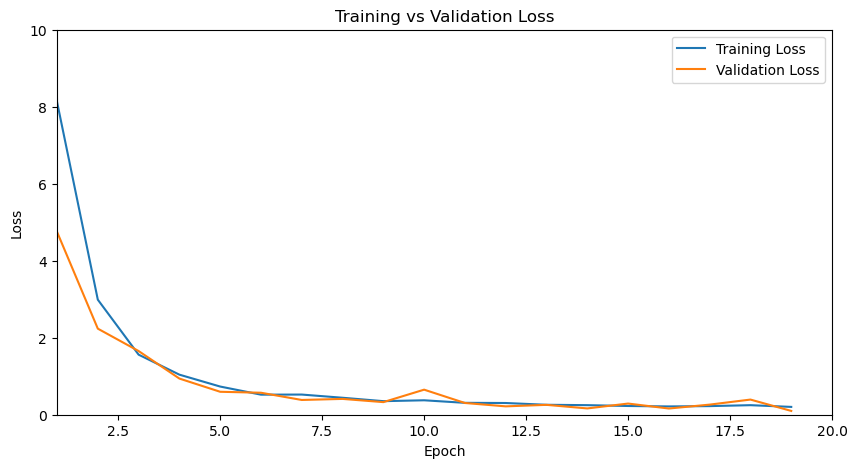

In [14]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(1, 20)  
plt.ylim(0, 10)  
plt.legend(loc='upper right')
plt.show()


## Display Ground Truth vs Predicted Coordinates for Validation Samples


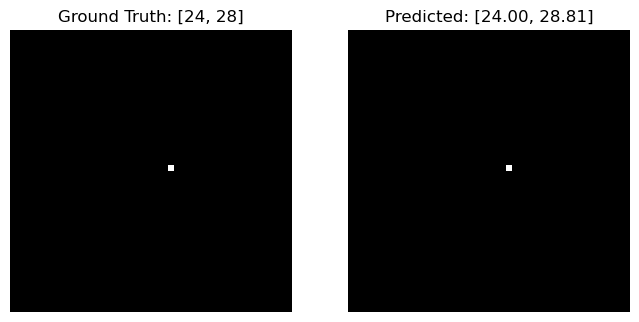

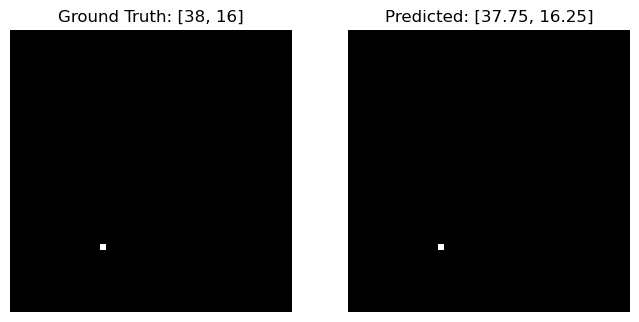

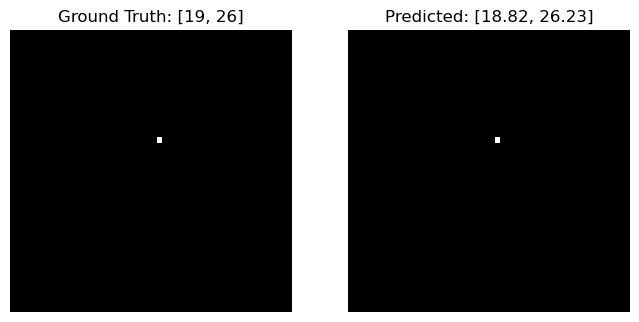

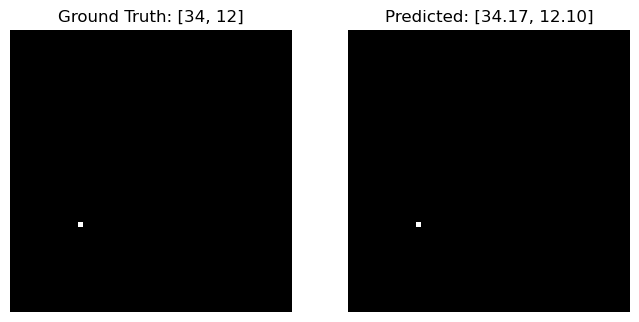

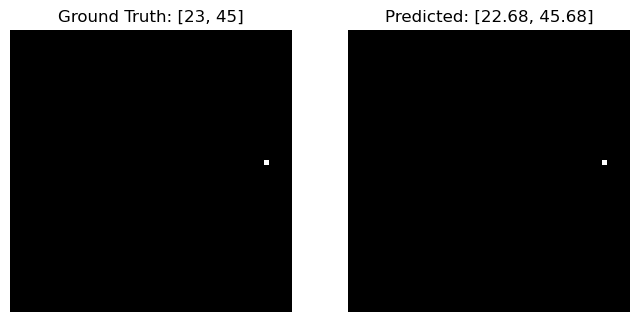

In [17]:
import matplotlib.pyplot as plt

# Number of samples to display
num_samples_to_display = 5

# Display the ground truth vs predicted coordinates for a few validation samples
for i in range(num_samples_to_display):
    plt.figure(figsize=(8, 4))
    
    # Display ground truth image
    plt.subplot(1, 2, 1)
    plt.imshow(X_val[i].reshape(50, 50), cmap='gray')
    plt.title(f"Ground Truth: [{y_val[i][0]}, {y_val[i][1]}]")
    plt.axis('off')
    
    # Display predicted image
    plt.subplot(1, 2, 2)
    plt.imshow(X_val[i].reshape(50, 50), cmap='gray')
    plt.title(f"Predicted: [{y_val_pred[i][0]:.2f}, {y_val_pred[i][1]:.2f}]")
    plt.axis('off')
    
    plt.show()
